## Motivation:
### - There are many available computer vision and deep learning pipelines available for Pose Estimation of the human body. 
### - These models provide a set of coordinates for various joints in the human body. Most of these models have been trained and tested on academic datasets like the Human 3.6M dataset.
### - Our work demonstrates how to use real-world data to compare the pose estimation as provided by the Microsoft Kinect to that provided by research pipelines based on convolutional and deep learning concepts.

### Note: Run a conda environment with the packages below before running the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
from matplotlib import gridspec
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
    

%matplotlib inline

### A map of how MPII joints relate to those provided by the Kinect

In [2]:
#MPII

# id - joint id (0 - r ankle - 18, 
#                1 - r knee - 17,
#                2 - r hip- 16, 
#                3 - l hip - 12, 
#                4 - l knee- 13, 
#                5 - l ankle - 14, 
#                6 - pelvis - 0, 
#                7 - thorax - 1, 
#                8 - upper neck- 2 , 
#                9 - head top - 3, 
#                10 - r wrist - 10, 
#                11 - r elbow - 9, 
#                12 - r shoulder - 8, 
#                13 - l shoulder - 4, 
#                14 - l elbow - 5, 
#                15 - l wrist - 6)

# Kinect  # from https://pterneas.com/2014/03/13/kinect-for-windows-version-2-body-tracking/
#   0            1        2           3           4            5            6        7                      
#SpineBase     SpineMid   Neck        Head        ShoulderLeft ElbowLeft   WristLeft HandLeft
#  8              9          10        11    .    12           13            14        15          
#ShoulderRight ElbowRight WristRight HandRight   HipLeft       KneeLeft    AnkleLeft FootLeft
#  16            17         18        19           20          21            22        23
#HipRight      KneeRight  AnkleRight  FootRight  SpineShoulder HandTipLeft ThumbLeft  HandTipRight
# 24
#ThumbRight


### Some helper methods

In [3]:
def get_data_dict(model_data_filename, image_filename, skeleton_filename):
    
    with open(model_data_filename, 'r') as f:
        coords = eval(f.read())

    x = np.array(coords)[:,0]*-1
    y = (np.array(coords)[:,1])*-1
    z = np.array(coords)[:,2]
    
    data_dict = [
        {
            'image': image_filename,
            'pose_estimate_data': [x,y,z],
            'kinect_data_file': skeleton_filename
        }     
    ]
    return data_dict

def plot_and_annotate_dataset(x,y, color, xPositionFactor, yPositionFactor,annotate):
    plt.scatter(x,y,color=color)
    points = np.arange(len(x))
    points_list = pd.Series(points).apply(lambda x: 'p_'+str(x) ).tolist()

    if annotate:
        for i in range(len(points)):
            plt.annotate(  points_list[i] , (x[i]*xPositionFactor, y[i]*yPositionFactor))    


def get_x_y_from_kinect(kinect_data_dict):
    x = []
    y = []
    z = []
    for join_data in kinect_data_dict['joints']:
        x.append(join_data['cameraX'])
        y.append(join_data['cameraY'])
        z.append(join_data['cameraZ'])
        
    return x, y , z
 
    
def get_scale(y1,y2,by='y'):
        # can use x1,y1 as well
        return (np.max(y2) - np.min(y2) ) / ( np.max(y1) - np.min(y1) )
    
        
def scale_translate_points(x,scale=1,translate=0):
    return list( (pd.Series(x)*scale) + translate)


def translation(scale,x1,y1,x2,y2):
    # assumption, x1,y1 and x2,y2 are head coordinates
    x1 = x1*scale
    y1 = y1*scale
    return (x2-x1) , (y2-y1)

def get_kinect_data(filename):

    with open(filename+".txt","r") as content_file:
        content = content_file.read()
        kinect_data_dict = json.loads(content)
        kinect_x, kinect_y , kinect_z =   get_x_y_from_kinect(kinect_data_dict)        
        return [kinect_x, kinect_y, kinect_z]


def get_loss(x1_arr,y1_arr,x2_arr,y2_arr,kinect_head_index,p,k,annotate=True,plot=True):
      
#     print("check scaling values for model and kinect")
#     print( np.max(y2_arr) - np.min(y2_arr) )
#     print( np.max(y1_arr) - np.min(y1_arr) )

    
    num_of_joints = len(p)

    assert len(p) == len(k)
    
    x_kinect = np.array(pd.Series(x1_arr)[k].reset_index(drop=True))
    y_kinect = np.array(pd.Series(y1_arr)[k].reset_index(drop=True))
    x_model = np.array(pd.Series(x2_arr)[p].reset_index(drop=True))
    y_model = np.array(pd.Series(y2_arr)[p].reset_index(drop=True))
    
    ##### Adding scaling and translation before we can calculate the loss ####

    plt.figure(figsize=(5,5), dpi=80)
    
    #print("scaling both to one unit")
    # scale both to height of one..
    x_kinect= x_kinect/( np.max(y_kinect) - np.min(y_kinect) )  
    y_kinect= y_kinect/( np.max(y_kinect) - np.min(y_kinect) )
    
    x_model=x_model/( np.max(y_model) - np.min(y_model) )
    y_model=y_model/( np.max(y_model) - np.min(y_model) )
    
    
    scale = get_scale(
        y_kinect,
        y_model
    )    
    
    #print("should be same scale; scale",scale)
 
    translate_x , translate_y = translation(scale,x_kinect[kinect_head_index],y_kinect[kinect_head_index], x_model[kinect_head_index], y_model[kinect_head_index])  

    x_kinect=scale_translate_points(x_kinect,scale=scale,translate=translate_x)
    y_kinect=scale_translate_points(y_kinect,scale=scale,translate=translate_y)
            
    kinect_pts = np.array(pd.Series(np.arange(num_of_joints)).apply(lambda i :  [x_kinect[i],y_kinect[i]] ).tolist())
    model_pts  = np.array(pd.Series(np.arange(num_of_joints)).apply(lambda i :  [x_model[i] , y_model[i]] ).tolist())

    
    
    #print('kinect_pts are')
    #print(kinect_pts)
    #print('model_pts are')
    #print(model_pts)    
        
    loss = paired_distances(kinect_pts, model_pts)   
    
    #print("loss distribution: (used to debug joint mapping issue)")
    #print(loss)
    
    if plot:
        plot_and_annotate_dataset(kinect_pts[:,0],kinect_pts[:,1], 'red',1.05, 0.95, annotate)    
        plot_and_annotate_dataset(model_pts[:,0], model_pts[:,1] , 'blue',1.05, 1.05,annotate)

        plt.show()

    return np.mean(loss) , np.std(loss) , loss



def scale_translate_and_plot(kinect_x,
                             kinect_y,
                             pose_estimate_data,
                             filename,
                             kinect_head_joint,
                             model_head_joint,
                             annotate
                            ):
    
    kinect_x = kinect_x
    kinect_y = kinect_y
    plt.figure(figsize=(3, 4), dpi=80)

    
    scale = get_scale(
        kinect_y,
        pose_estimate_data[1]
    )    
 
    translate_x , translate_y = translation(scale,kinect_x[kinect_head_joint],kinect_y[kinect_head_joint], pose_estimate_data[0][model_head_joint], pose_estimate_data[1][model_head_joint])  

    x1=scale_translate_points(kinect_x,scale=scale,translate=translate_x)
    y1=scale_translate_points(kinect_y,scale=scale,translate=translate_y)
    x2=pose_estimate_data[0]
    y2=pose_estimate_data[1]    

    cdict = {1: 'red', 2: 'blue', 3: 'green'}

    plt.figure(figsize=(10,10), dpi=80)

    
    plot_and_annotate_dataset(x1,y1, 'red',1.05, 0.95, annotate)
    
    plot_and_annotate_dataset(x2,y2, 'blue',1.05, 1.05,annotate)

def perform_pose_analysis(data_dict, model_joint_indeces, kinect_joint_indeces):
    
    data = data_dict[0]
    kinect_points = get_kinect_data(data['kinect_data_file'])
    
    
    pose_data = data['pose_estimate_data']
    kinect_arr = get_kinect_data(data['kinect_data_file'])
    
    plt.figure(figsize=(5, 5), dpi=80)    
    
    scale_translate_and_plot(
                                     kinect_arr[0],
                                     kinect_arr[1],
                                     pose_data,
                                     data['image'],
                                     3,
                                     9,
                                     True
                                    )    
    
    loss_mean, loss_std, loss_arr = get_loss(kinect_arr[0], kinect_arr[1],pose_data[0], pose_data[1],9, model_joint_indeces, kinect_joint_indeces, plot=False)          
    plt.hist(loss_arr)    
    print("loss mean :",str(loss_mean))
    print("loss std :",str(loss_std))
    print(loss_arr)


## Time to compare different models!

### Model - pytorch-pose-hg-3d


In [7]:
kinect_joint_indeces_pytorch_pose_hgmodel = [0,16,17,18,12,13,14,1 ,2 ,3 ,4 , 9,6, 8 , 10]
model_joint_indeces_pytorch_pose_hgmodel= [6, 2, 1, 0, 3, 4, 5,7, 8, 9, 13,11,15,12, 10 ]


loss mean : 0.05980275113648551
loss std : 0.03112374568953733
[0.04430522 0.03036804 0.06188958 0.05823049 0.03364092 0.04320102
 0.03263612 0.07917014 0.13772251 0.         0.06483712 0.08617274
 0.06819346 0.06790348 0.08877041]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

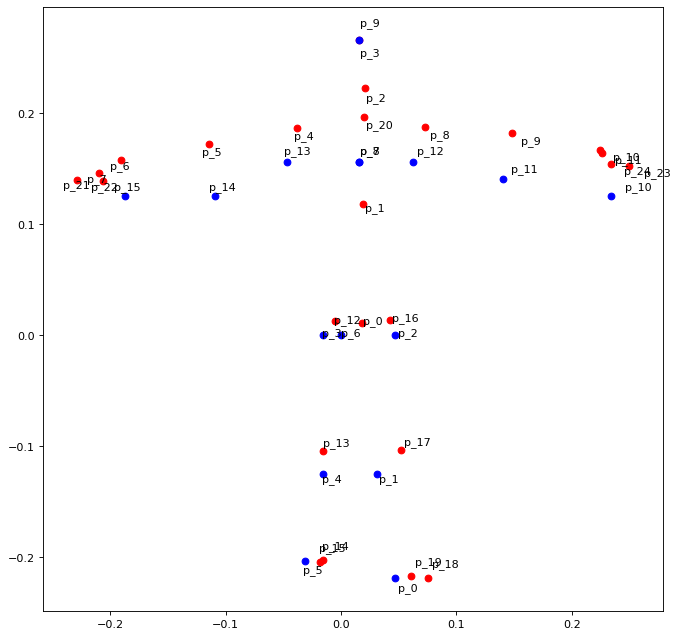

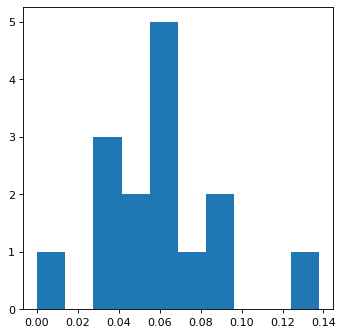

In [8]:
pose_estimate_data_new = get_data_dict('pytorch_pose_hg/10.txt', 'images/output_10.jpg' ,'kinect/skeleton_10')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_pytorch_pose_hgmodel, kinect_joint_indeces_pytorch_pose_hgmodel)


loss mean : 0.050040812554777665
loss std : 0.03718046829255603
[0.03034616 0.01251957 0.05120944 0.01940457 0.01403266 0.04814889
 0.00917989 0.08088677 0.13997657 0.         0.05983849 0.09340018
 0.04206411 0.06430414 0.08530074]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

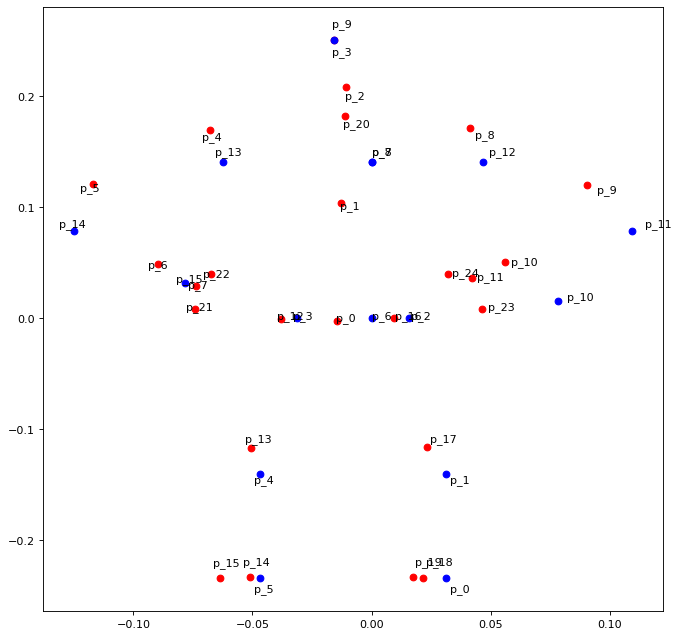

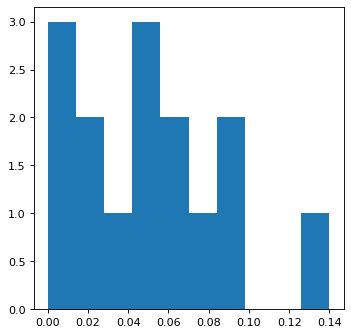

In [9]:
pose_estimate_data_new = get_data_dict('pytorch_pose_hg/20.txt', 'images/output_20.jpg' ,'kinect/skeleton_20')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_pytorch_pose_hgmodel, kinect_joint_indeces_pytorch_pose_hgmodel)


loss mean : 0.13490642302983147
loss std : 0.11462517462898232
[0.06547484 0.08529582 0.15719839 0.2141418  0.06442145 0.08896663
 0.05471152 0.06542813 0.14395056 0.         0.09580233 0.1479017
 0.46731653 0.06630319 0.30668345]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

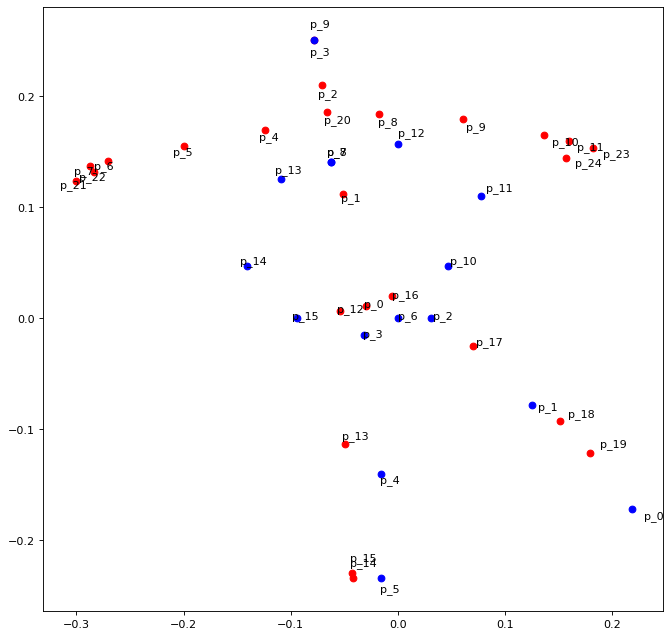

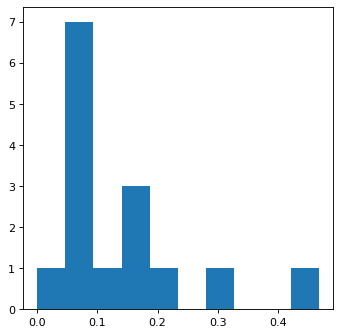

In [10]:
pose_estimate_data_new = get_data_dict('pytorch_pose_hg/30.txt', 'images/output_30.jpg' ,'kinect/skeleton_30')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_pytorch_pose_hgmodel, kinect_joint_indeces_pytorch_pose_hgmodel)


### Model - Simple Baselines for Human Pose Estimation


In [11]:
kinect_joint_indeces_sbhpe = [0,16,17,18,12,13,14,1 ,2 ,3 ,4 , 9,6, 8 , 10]
model_joint_indeces_sbhpe  = [6, 2, 1, 0, 3, 4, 5,7, 8, 9, 13,11,15,12, 10]


In [12]:
def get_data_dict_2d(model_data_filename, image_filename, skeleton_filename):
    
    with open(model_data_filename, 'r') as f:
        coords = eval(f.read())

    x = np.array(coords)[:,0]*-(1280/720)
    y = (np.array(coords)[:,1])*-1
    
    data_dict = [
        {
            'image': image_filename,
            'pose_estimate_data': [x,y],
            'kinect_data_file': skeleton_filename
        }     
    ]
    return data_dict


loss mean : 0.07336183630598406
loss std : 0.049094179142897994
[5.19527362e-02 5.89442634e-02 2.10079098e-02 1.91122689e-01
 5.48294161e-02 1.93531914e-02 1.58986524e-01 9.97674607e-02
 6.61683037e-02 2.77555756e-17 6.01095672e-02 9.44229272e-02
 7.41446281e-02 4.71333371e-02 1.02484591e-01]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

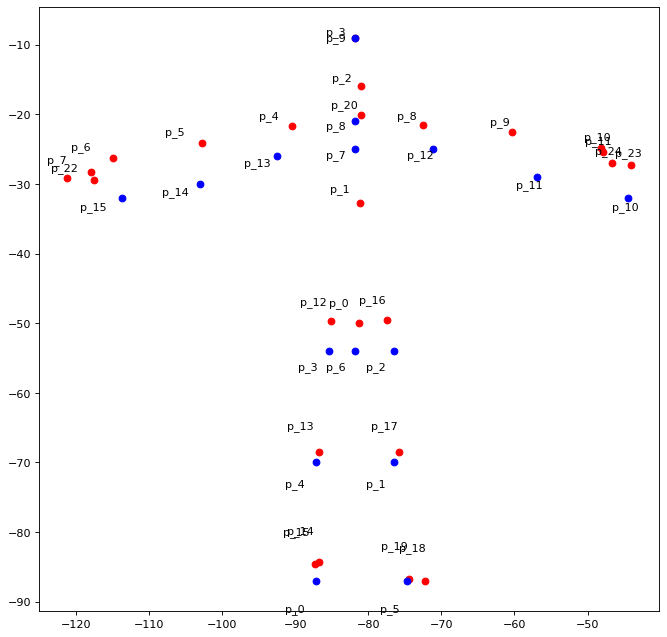

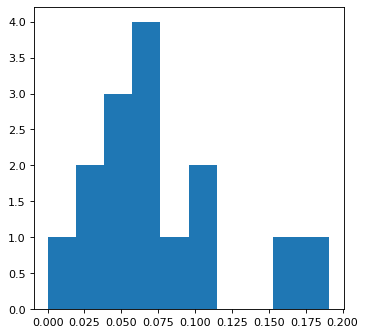

In [14]:
pose_estimate_data_new = get_data_dict_2d('sbhpe/10.txt', 'images/output_10.jpg' ,'kinect/skeleton_10')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_sbhpe, kinect_joint_indeces_sbhpe)


loss mean : 0.04871892790075652
loss std : 0.02842037777854528
[0.04793816 0.04291691 0.01875693 0.00899355 0.05648376 0.02410185
 0.01765606 0.08458334 0.06699793 0.         0.06412985 0.09446695
 0.07071544 0.05020493 0.08283825]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

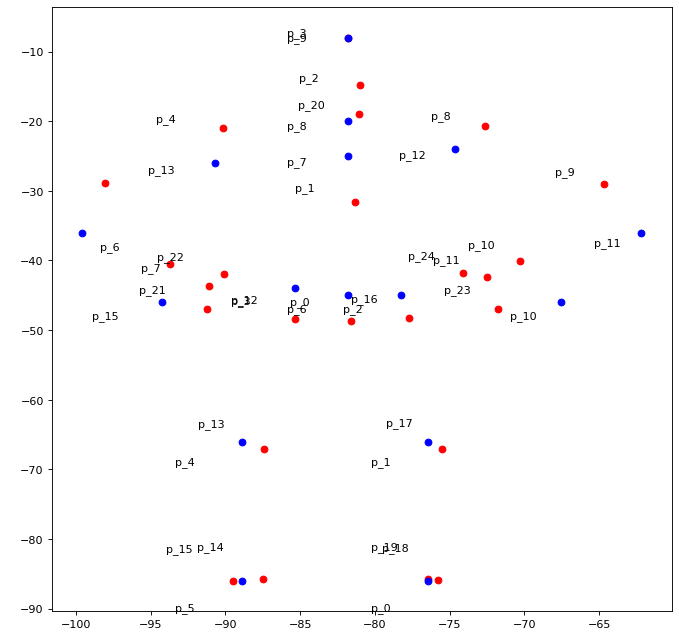

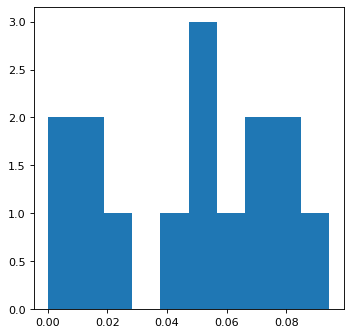

In [15]:
pose_estimate_data_new = get_data_dict_2d('sbhpe/20.txt', 'images/output_20.jpg' ,'kinect/skeleton_20')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_sbhpe, kinect_joint_indeces_sbhpe)


loss mean : 0.14671326543506819
loss std : 0.11716199145258638
[8.44180462e-02 7.71144627e-02 1.84372415e-01 2.60355749e-01
 6.62207157e-02 1.22432948e-01 1.05707390e-01 9.05424644e-02
 1.10851972e-01 1.38777878e-17 9.37814697e-02 1.42837435e-01
 5.05677296e-01 9.31154868e-02 2.63271132e-01]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

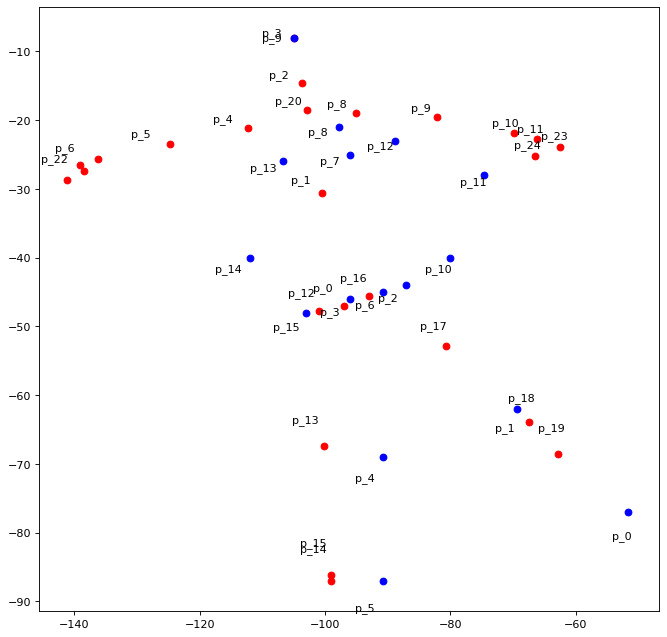

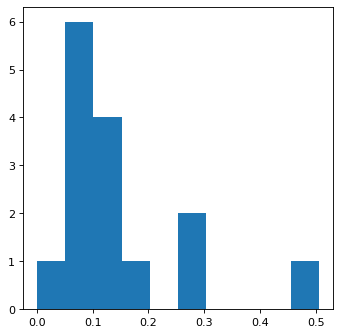

In [16]:
pose_estimate_data_new = get_data_dict_2d('sbhpe/30.txt', 'images/output_30.jpg' ,'kinect/skeleton_30')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_sbhpe, kinect_joint_indeces_sbhpe)


### Model - Mobile Pytorch


In [17]:
kinect_joint_indeces_mobile_pytorch = [0,16,17,18,12,13,14,1 ,2 ,3 ,4 , 9,6, 8 , 10]
model_joint_indeces_mobile_pytorch = [6, 2, 1, 0, 3, 4, 5,7, 8, 9, 13,11,15,12, 10]


loss mean : 0.11697094249375553
loss std : 0.10539925790601415
[0.04041174 0.06557028 0.07208464 0.01802695 0.06473768 0.06893001
 0.0703638  0.099824   0.09474954 0.         0.12943422 0.21706086
 0.32406206 0.10504317 0.38426519]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

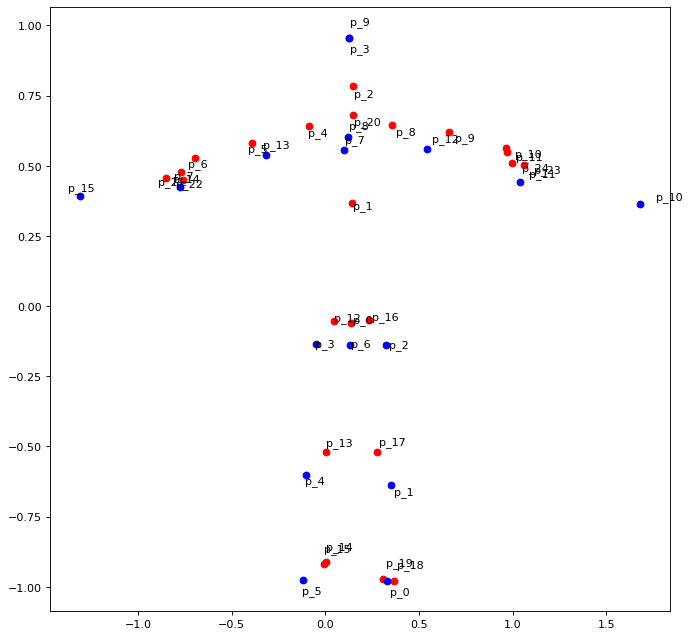

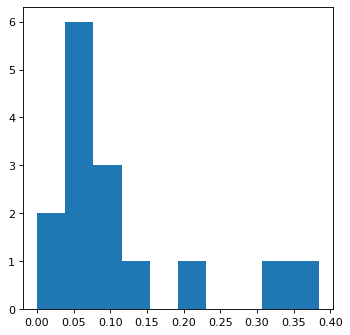

In [18]:
pose_estimate_data_new = get_data_dict_2d('mobile-pytorch/10.txt', 'images/output_10.jpg' ,'kinect/skeleton_10')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_sbhpe, kinect_joint_indeces_sbhpe)


loss mean : 0.09465506906685812
loss std : 0.052326683860635256
[5.24906816e-02 1.01938241e-01 9.98021870e-02 5.90310423e-02
 5.34801620e-02 1.03016227e-01 5.49657298e-02 8.32027121e-02
 9.96836705e-02 5.59431511e-17 8.67584342e-02 2.34978660e-01
 9.56609290e-02 1.38236259e-01 1.56581101e-01]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

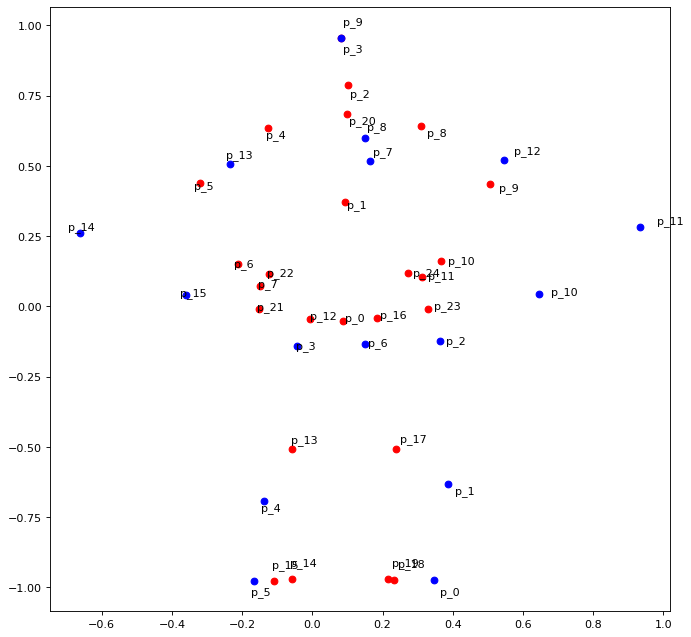

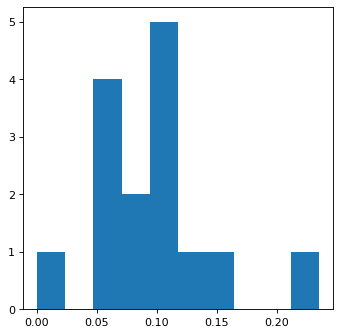

In [20]:
pose_estimate_data_new = get_data_dict_2d('mobile-pytorch/20.txt', 'images/output_20.jpg' ,'kinect/skeleton_20')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_sbhpe, kinect_joint_indeces_sbhpe)


loss mean : 0.26243487970818175
loss std : 0.17568275761774182
[2.35790605e-01 3.10315825e-01 5.16625368e-01 6.73164853e-01
 1.65189170e-01 2.23551347e-01 2.41367123e-01 8.36177219e-02
 1.22115645e-01 5.55111512e-17 9.04819978e-02 3.51614860e-01
 4.86706815e-01 1.79695222e-01 2.56286644e-01]


<Figure size 400x400 with 0 Axes>

<Figure size 240x320 with 0 Axes>

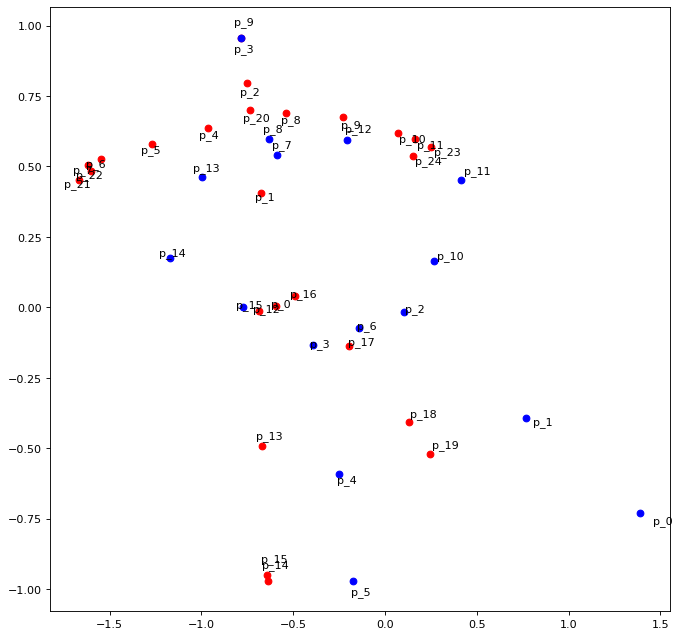

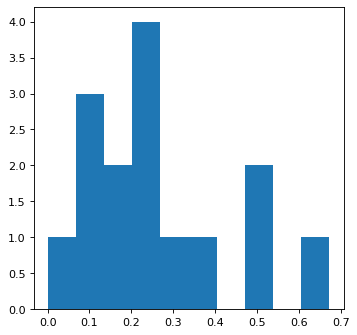

In [19]:
pose_estimate_data_new = get_data_dict_2d('mobile-pytorch/30.txt', 'images/output_30.jpg' ,'kinect/skeleton_30')
perform_pose_analysis(pose_estimate_data_new, model_joint_indeces_sbhpe, kinect_joint_indeces_sbhpe)


## Final Result Comparison

Model  | Mean Loss(SD) for Figure A | Mean Loss(SD) for Figure B | Mean Loss(SD) for 0.059Figure C
------------- | -------------| -------------| -------------
pytorch-pose-hg-3d | 0.059(0.031) | 0.050(0.037) | 0.134(0.114)
Simple Baselines for Human Pose Estimation | 0.073(0.049) | 0.0487(0.0284) | 0.1467(0.117)
Mobile Pytorch  | 0.1169(0.105) | 0.094(0.052) | 0.262(0.175)


In [ ]:
#Uncomment for running as separate scatterplots
# plot_and_annotate_dataset(data['pose_estimate_data'][0], 
#                               data['pose_estimate_data'][1],
#                               'blue',
#                               1.05, 
#                               1.05,
#                              True)
    
# plot_and_annotate_dataset(kinect_points[0], 
#                              kinect_points[1],
#                               'red',
#                                1.2, 
#                                1.2,
#                              True)
    